In [1]:
import numpy as np
import pandas as pd
import os
import time
import json
import gc
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 第一步，我们先把json格式展开

In [ ]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
train = load_df('/home/leechh/data/R/train.csv')
gc.collect()

In [ ]:
train.to_feather('/home/leechh/tempfile/R/train.feather')

In [2]:
train = pd.read_feather('/home/leechh/tempfile/R/train.feather')

In [3]:
train.head(5)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,None,None,None,(not set),None,None,(not provided),organic,None,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,None,None,None,(not set),None,None,(not provided),organic,None,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,None,None,None,(not set),None,None,(not provided),organic,None,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,None,None,None,(not set),None,None,google + online,organic,None,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,None,None,None,(not set),None,True,(not provided),organic,None,google


### totals_transactionRevenue

首先呢，我们先看看我们要预测的transactionRevenue 大概是什么样，

In [4]:
train['totals_transactionRevenue'] = train.totals_transactionRevenue.astype('float')

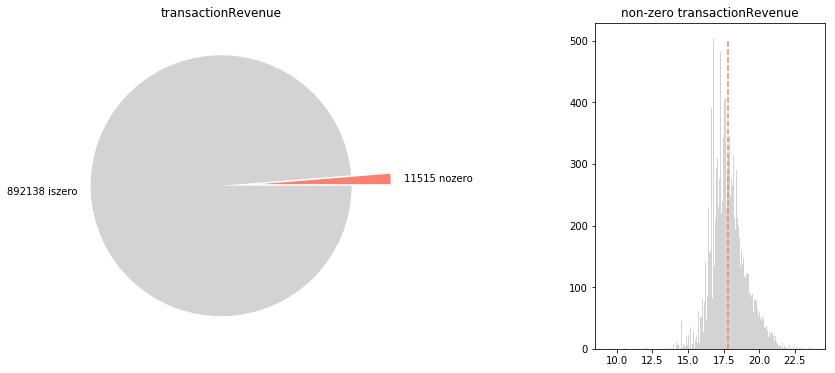

In [5]:
def plotRevence():
    idx = train.totals_transactionRevenue.notnull()
    nozero = sum(idx)
    iszero = train.shape[0] - nozero
    plt.figure(figsize=[14,6])
    plt.subplot(1,2,1)
    plt.pie([nozero,iszero],
            labels=[f'{nozero} nozero',f'{iszero} iszero'],
            radius=1,
            colors=['salmon','lightgray'], 
            explode=[0.3,0])
    plt.title('transactionRevenue')

    plt.subplot(1,3,3)
    revenue = np.log1p(train[idx].totals_transactionRevenue.astype('float')+1)
    plt.hist(revenue, 
             bins=200, 
             color='lightgray')
    plt.plot([np.average(revenue),np.average(revenue)],[0,500],c='salmon',linestyle='--')
    plt.title('non-zero transactionRevenue')
    plt.show()
    return None


plotRevence()

In [6]:
train['target'] = np.log1p(train.totals_transactionRevenue.fillna(0,inplace=False))

我们可以看到，可以说20/80法则发挥着决定性的作用，绝大多数的点击量都是没有成交的，只有大概百分之一的进入是会成交的，而在成交的金额上，在经过ln之后基本符合正态分布，这是个不错的开始。

### channelGrouping 

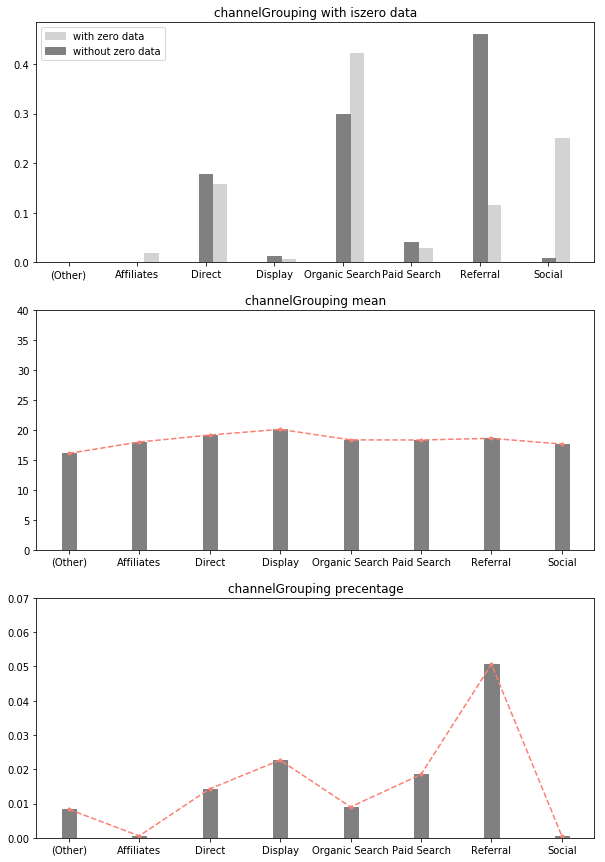

In [7]:
def plotchannel():
    channel = train.channelGrouping.value_counts(dropna=True,normalize=True).sort_index()
    idx = train.totals_transactionRevenue.notnull()
    channel2 = train[idx].channelGrouping.value_counts(dropna=True,normalize=True).sort_index()
    channelmean = train.groupby('channelGrouping').mean().totals_transactionRevenue
    channelpercentage = train[idx].channelGrouping.value_counts(dropna=True,normalize=False)/ train.channelGrouping.value_counts(dropna=True,normalize=False)

    plt.figure(figsize=[10,15])
    plt.subplot(3,1,1)
    plt.bar(np.arange(channel.shape[0])+1,
            channel.values,
            width=np.ones(8)*0.2,
            facecolor='lightgray',
            edgecolor='lightgray',
            tick_label=channel.index.values,
            label='with zero data')
    plt.bar(np.arange(channel2.shape[0])+0.8,
            channel2.values,
            width=np.ones(8)*0.2,
            facecolor='gray',
            edgecolor='gray',
            tick_label=channel.index.values,
            label='without zero data')
    plt.title('channelGrouping with iszero data')
    plt.legend()

    plt.subplot(3,1,2)
    plt.bar(np.arange(channel2.shape[0])+1,
            np.log1p(channelmean.values+1),
            facecolor='gray',
            width=np.ones(8)*0.2,
            edgecolor='gray',
            tick_label=channelmean.index.values)
    plt.plot(np.arange(channel2.shape[0])+1,np.log1p(channelmean.values+1),'.--',c='salmon')
    plt.title('channelGrouping mean')
    plt.ylim([0,40])

    plt.subplot(3,1,3)
    plt.bar(np.arange(channelpercentage.shape[0])+1,
            channelpercentage.values,
            facecolor='gray',
            width=np.ones(8)*0.2,
            edgecolor='gray',
            tick_label=channelpercentage.index.values)
    plt.plot(np.arange(channel2.shape[0])+1,channelpercentage.values,'.--',c='salmon')
    plt.title('channelGrouping precentage')
    plt.ylim([0,0.07])
    plt.show()
    return None

plotchannel()

结论： 由上图我们可以看出，social项拥有很高的浏览量，但是成交比很低，很多人都只是单纯的点进来看看，并没有买任何东西。social项很可能指的是网站在社交媒体上投放广告。反之Referral项虽然没有太多的浏览量，但是成交比却很高。 当然，关键词广告自然搜索所占浏览量很大，但是成交比并不大。

### 我觉得seesionId 应该就是fullvisitId 与 visitId 的结合，验证以下，如果是的话，我们就可以把 这个features去掉了。

In [8]:
print('fullvisitId sess diff:',sum(train.sessionId.str.split('_',expand=True)[0] != train.fullVisitorId))
print('visitId sess diff:',sum(train.sessionId.str.split('_',expand=True)[1] != train.visitId.astype('str')))

fullvisitId sess diff: 0
visitId sess diff: 0


In [9]:
train.drop(['sessionId'],axis=1,inplace=True)

### 接下来，把时间date转化为时间格式

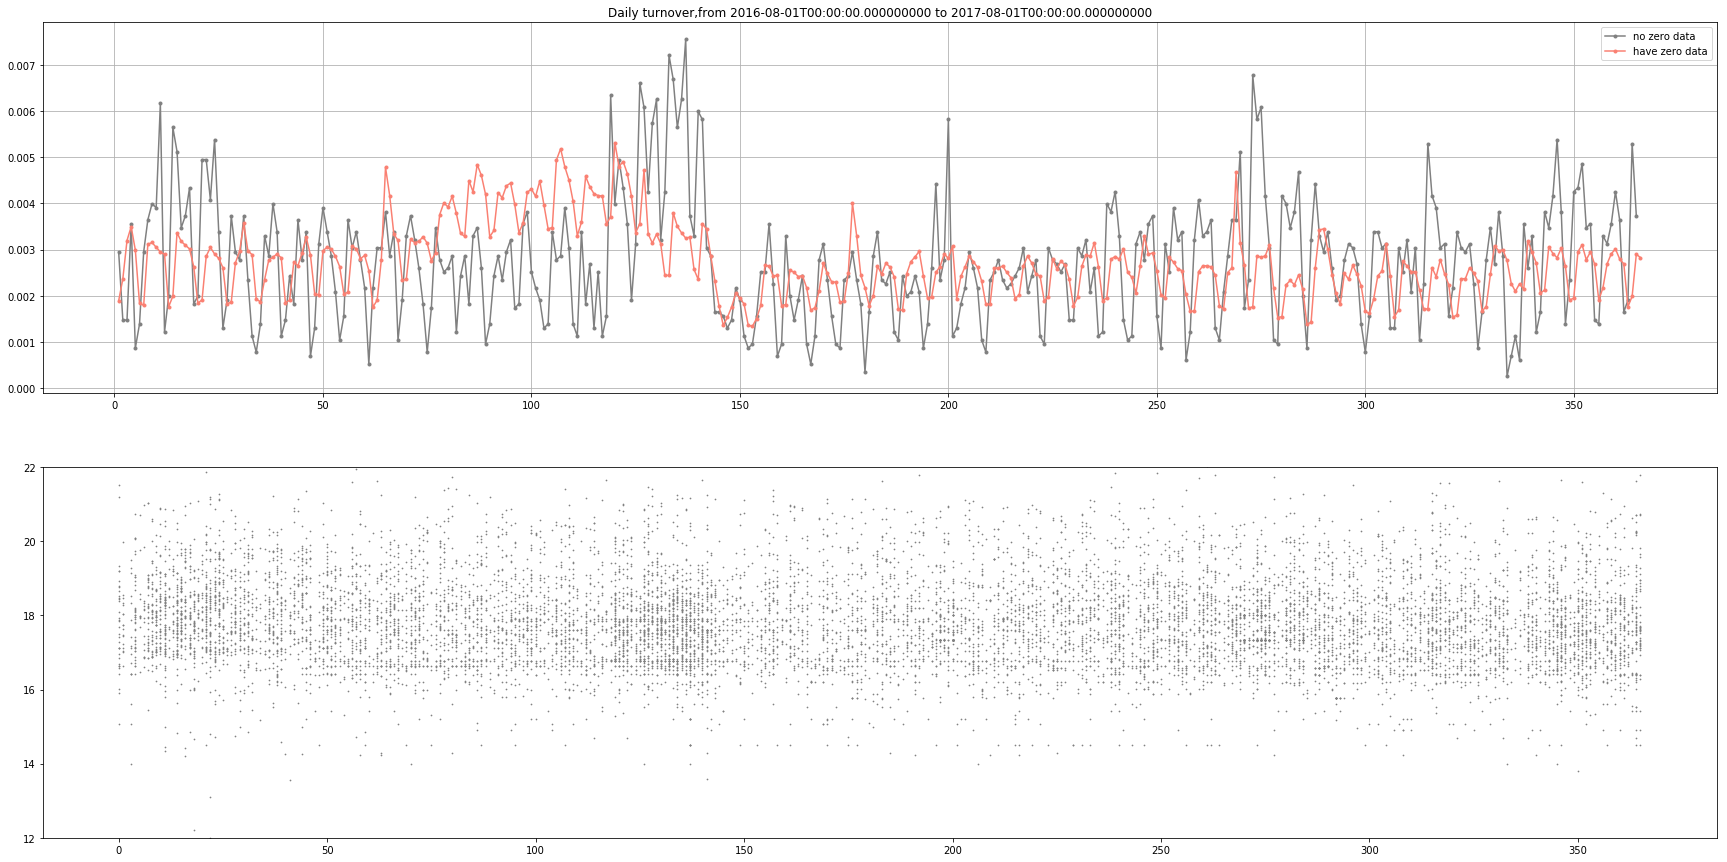

In [10]:
train['date'] = pd.to_datetime(train.date,format='%Y%m%d')


def plotdate():
    idx = train.totals_transactionRevenue.notnull()
    datetime1 = train[idx].date.value_counts(normalize=True).sort_index()
    datetime2 = train.date.value_counts(normalize=True).sort_index()
    tofirst = np.array([i.days for i in train[idx].date-datetime1.index.values[0]])
    plt.figure(figsize=[30,15])
    plt.subplot(2,1,1)
    plt.title(f'Daily turnover,from {datetime1.index.values[0]} to {datetime1.index.values[-1]}')
    plt.plot(np.arange(datetime1.shape[0])+1,
             datetime1.values,
             '.-',
             c='gray',
             label='no zero data')
    plt.plot(np.arange(datetime2.shape[0])+1,
             datetime2.values,
             '.-',
             c='salmon',label='have zero data')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.scatter(tofirst,np.log1p(train[idx].totals_transactionRevenue+1),s=0.5,alpha=1,c='gray')
    plt.ylim([12,22])
    plt.show()
    return None


plotdate()

从这个图我们可以看出一些特别有趣的现象，首先浏览量是以一周为周期变化的，所以我们应该创建一个UTC星期特征。但是，由下图可知，时间与金额无关。

In [11]:
train['week'] = train.date.apply(lambda t: t.dayofweek)

### socialEngagementType

In [12]:
idx = (train.socialEngagementType != 'Not Socially Engaged')
sum(idx)

0

In [13]:
train.drop(['socialEngagementType'], axis=1, inplace=True)

In [14]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,...,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,target,week
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,...,None,(not set),None,None,(not provided),organic,None,google,0.0,4
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,...,None,(not set),None,None,(not provided),organic,None,google,0.0,4
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,...,None,(not set),None,None,(not provided),organic,None,google,0.0,4
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,...,None,(not set),None,None,google + online,organic,None,google,0.0,4
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,not available in demo dataset,not available in demo dataset,mobile,...,None,(not set),None,True,(not provided),organic,None,google,0.0,4


### visitNumber

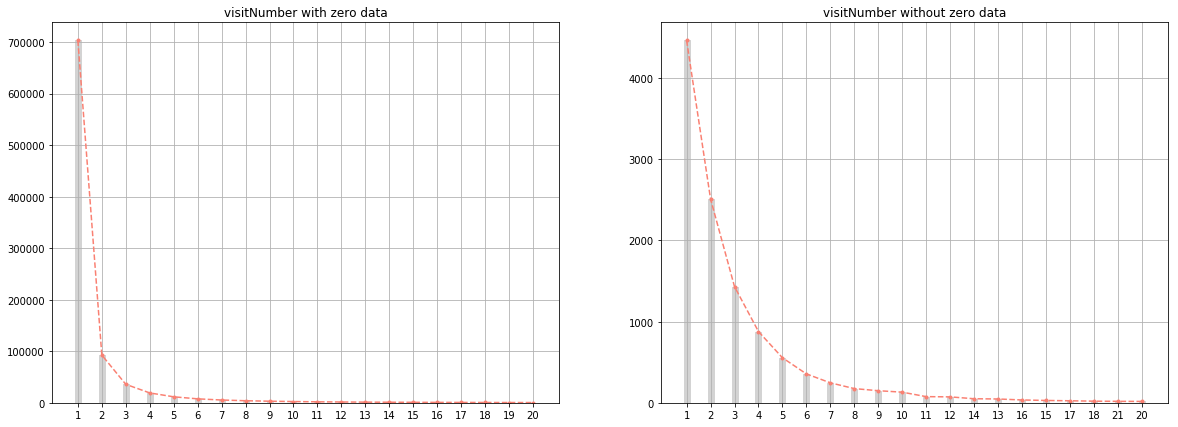

In [15]:
def plotvisitnumber():
    idx = (train.totals_transactionRevenue.notnull())
    vn1 = train.visitNumber.value_counts(dropna=False)[0:20]
    vn2 = train[idx].visitNumber.value_counts(dropna=False)[0:20]
    plt.figure(figsize=[20,7])
    plt.subplot(1,2,1)
    plt.bar(np.arange(vn1.shape[0])+1,
            vn1.values,
            facecolor='lightgray',
            width=np.ones(20)*0.25,
            edgecolor='lightgray',
            tick_label=vn1.index.values)
    plt.plot(np.arange(vn1.shape[0])+1,
             vn1.values,'.--', 
             c='salmon')
    plt.title('visitNumber with zero data')
    plt.grid()
    plt.subplot(1,2,2)
    plt.bar(np.arange(vn2.shape[0])+1,
            vn2.values,
            facecolor='lightgray',
            width=np.ones(20)*0.25,
            edgecolor='lightgray',
            tick_label=vn2.index.values)
    plt.plot(np.arange(vn2.shape[0])+1,
             vn2.values,'.--', 
             c='salmon')
    plt.title('visitNumber without zero data')
    plt.grid()
    plt.show()
    return None


plotvisitnumber()

(0, 50)

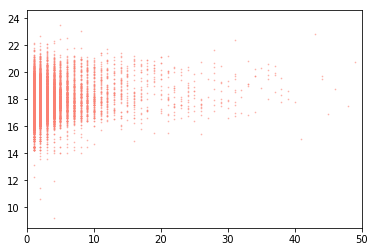

In [16]:
plt.scatter(train.visitNumber,np.log1p(train.totals_transactionRevenue+1),s=0.5,alpha=0.5,c='salmon')
plt.xlim([0,50])

我们可以看到，visitNumber及其不平衡，大多数为1，由kaggle官方提供的说明，If this is the first session, then this is set to 1，所以大多数都是用户初次访问,但是对于成交的浏览来说，曲线更平缓一些。但是成交金额与浏览次数没有线性关系

### visitStartTime
The timestamp (expressed as POSIX time)， so we convert it to a pd.datatime

In [17]:
def totime(t):
    year = time.localtime(t)[0]
    month = time.localtime(t)[1]
    day = time.localtime(t)[2]
    hour = time.localtime(t)[3]
    minute = time.localtime(t)[4]
    second = time.localtime(t)[5]
    return pd.Timestamp(year,month,day,hour,minute,second)


train['visitStartTime'] = train.visitStartTime.map(totime)

这个features, 因为使用的是UTC，所以在时间上面有一定偏移，在之后的工作中，如果我们能否通过所在地区找到其时区，便能探索具体时间对于结果的影响。

### 去掉重复features

In [18]:
for i in train.columns:
    if sum(train[i] == train[i][0]) == train.shape[0]:
        train.drop([i], axis=1, inplace=True)
print(f'After drop feature Number is: {train.shape[1]}')

After drop feature Number is: 37


### device

In [19]:
train.iloc[:,6:10].head()

,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem
0,Chrome,desktop,False,Windows
1,Firefox,desktop,False,Macintosh
2,Chrome,desktop,False,Windows
3,UC Browser,desktop,False,Linux
4,Chrome,mobile,True,Android


In [20]:
# 我们去掉device_isMobile
train.drop(['device_isMobile'], axis=1, inplace=True)

我们可以看到device_operatingSystem 有较多(not set)项目 ，我们前期可以先去掉这些数据，在后期可以用机器学习的方法找到其真实值

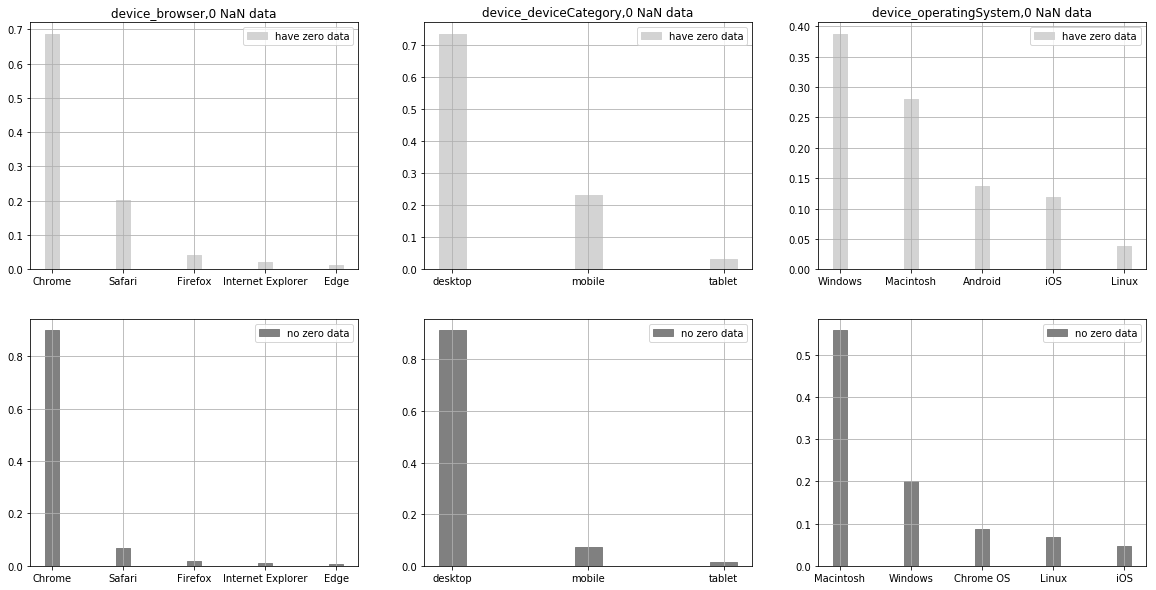

In [21]:
def plotdevice(df,top=10):
    n = 1
    plt.figure(figsize=[20,10])
    for i in df.columns[6:9]:
        idx = train.totals_transactionRevenue.notnull()
        value_count1 = train[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = train[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(2,3,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},{sum(train[i].isnull())} NaN data')
        plt.grid()
        plt.subplot(2,3,n+3)
        plt.grid()
        plt.bar(np.arange(value_count2.shape[0])+1.2,
                value_count2.values,           
                width=np.ones(value_count2.shape[0])*0.2,
                facecolor='gray',
                edgecolor='gray',
                tick_label=value_count2.index.values,
                label='no zero data')
        plt.legend()
        n = n+1
    plt.show()
    return None


plotdevice(train,top=5)

我们可以看到，虽然chrome浏览器拥有较高的市场占有率，但是chrome用户也拥有更高的购买热情，可能都是google的死忠？ps:I use firefox.:)   
以及大家用桌面机的时候更倾向于交易，可能是交易需要信用卡等等信息，比较麻烦，或者单纯因为app做的不好？有趣的是mac用户拥有更高的交易意愿，可能是因为Mac比较贵？


### geoNetwork

In [22]:
train.iloc[:,9:16].head()

,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent
0,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia
1,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia
2,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe
3,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia
4,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe


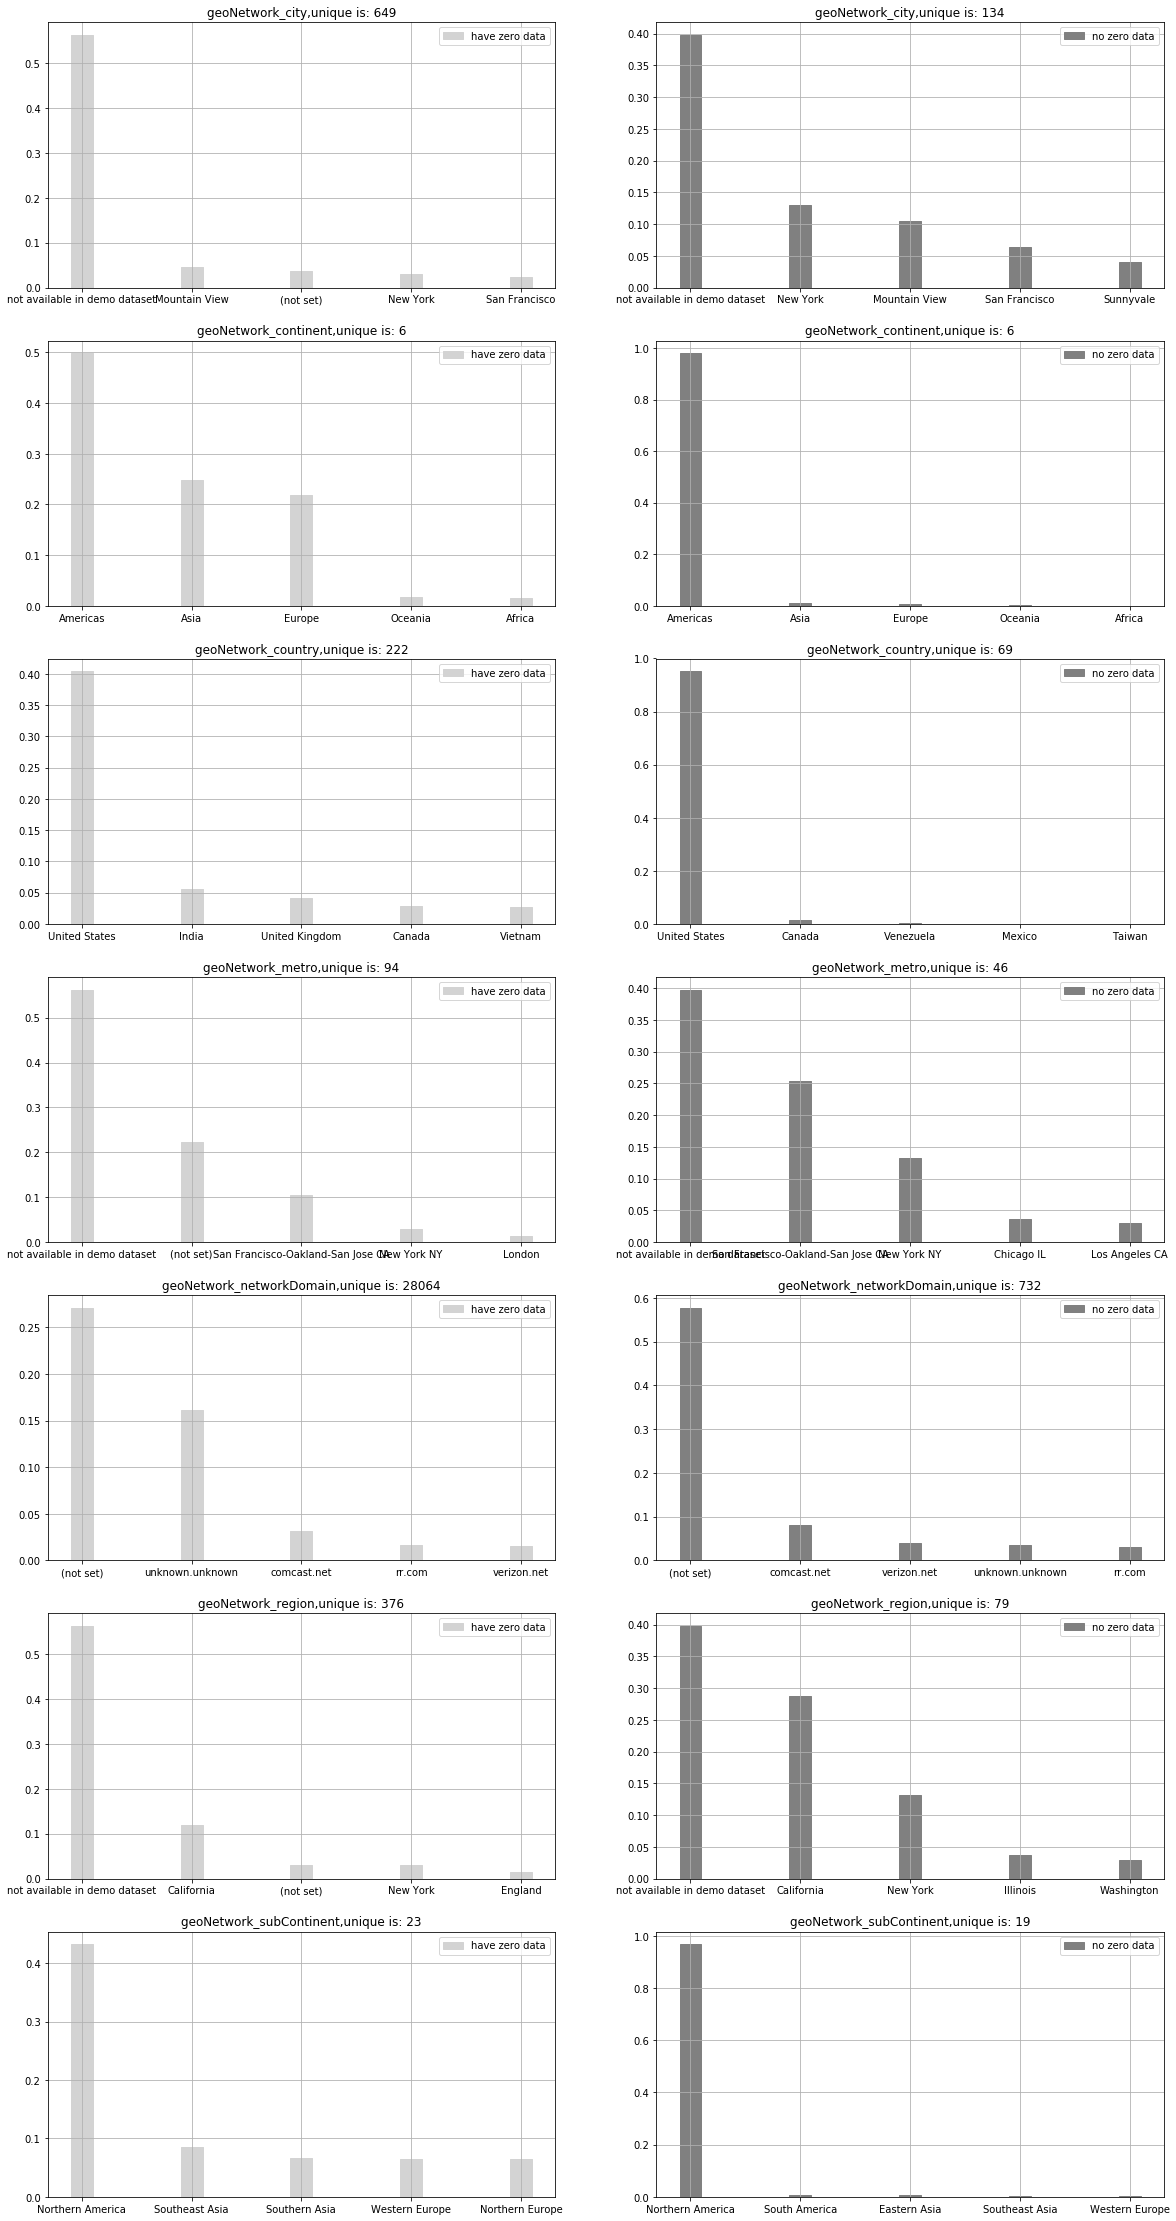

In [23]:
def plotgeonetwork(df,top=10):
    n = 1
    plt.figure(figsize=[20,40])
    for i in df.columns[9:16]:
        idx = df.totals_transactionRevenue.notnull()
        value_count1 = df[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = df[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(7,2,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},unique is: {df[i].nunique()}')
        plt.grid()
        plt.subplot(7,2,n+1)
        plt.grid()
        plt.bar(np.arange(value_count2.shape[0])+1.2,
                value_count2.values,           
                width=np.ones(value_count2.shape[0])*0.2,
                facecolor='gray',
                edgecolor='gray',
                tick_label=value_count2.index.values,
                label='no zero data')
        plt.title(f'{i},unique is: {df[idx][i].nunique()}')
        plt.legend()
        n = n+2
    plt.show()
    return None


plotgeonetwork(train,top=5)

我们似乎可以看到，尽管全球都有浏览量，但是貌似绝大多数都是美国人在购买，并且这几个features都存在大量诸如not set，not available in demo dataset 之类的变量，之后我们要看看造成这种现象的原因。 

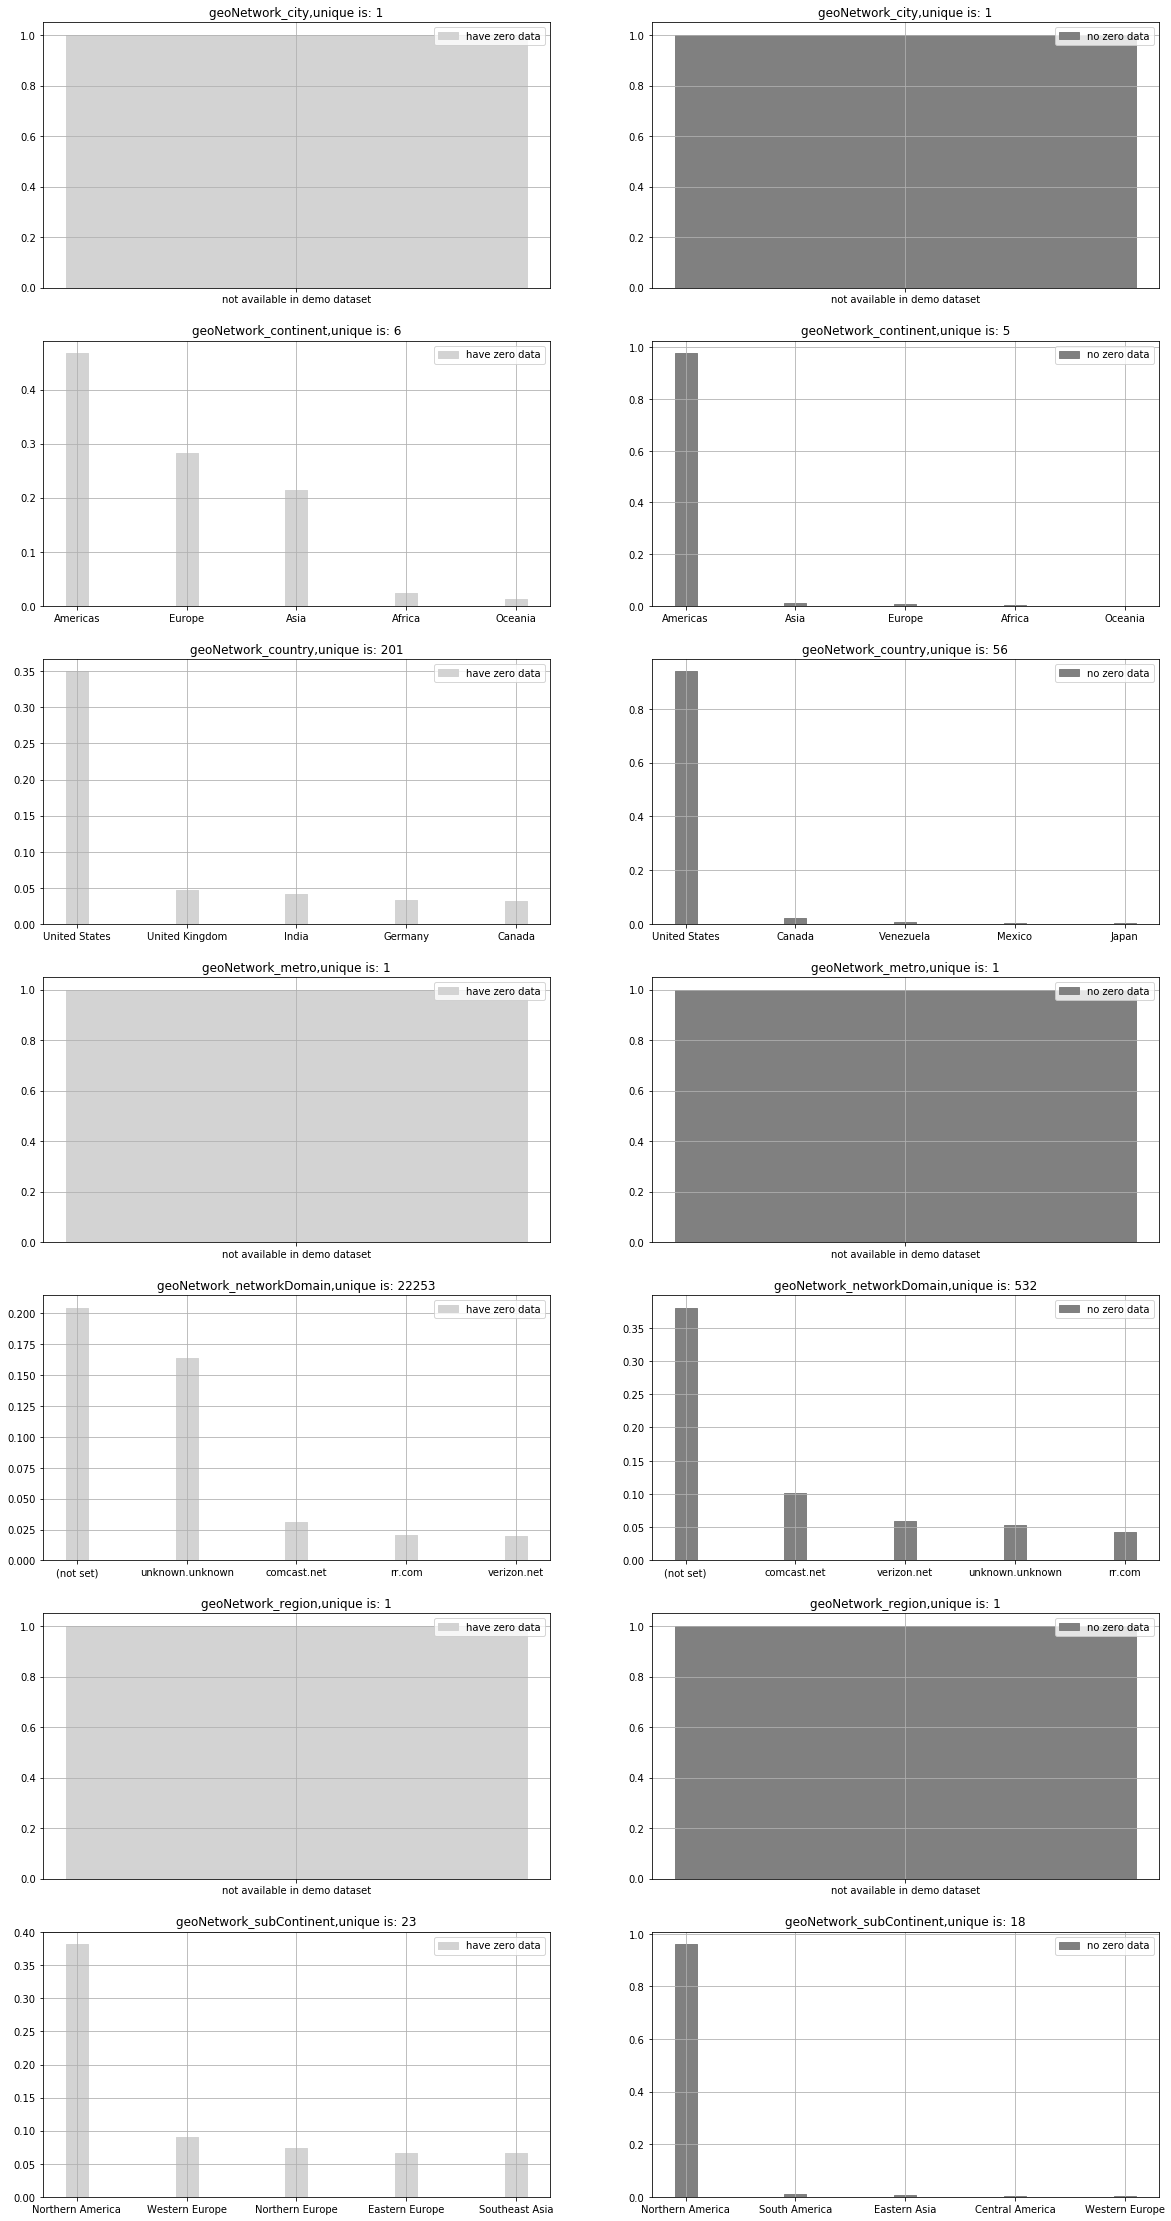

In [24]:
index =  train.geoNetwork_city == 'not available in demo dataset'
plotgeonetwork(train[index],top=5)

啊哈，一个有趣的发现，那就是city中的的not available in demo dataset其实是在city，metro,region都是not available in demo dataset的。而在其他几项中并没有明显不同，说明造成not available in demo dataset的原因与地域没有太多关系。在之后的工作中，我们可以创建一个‘is not available’特征，然后用机器学习的方法预测出其本来值。

In [25]:
train['is not available'] = train.geoNetwork_city == 'not available in demo dataset'

### totals

In [26]:
train.iloc[:,16:20].head()

,totals_bounces,totals_hits,totals_newVisits,totals_pageviews
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,None,1


In [27]:
sum(train.totals_pageviews.isnull())

100

In [28]:
train['totals_bounces'] = train.totals_bounces.fillna(0)
train['totals_newVisits'] = train.totals_newVisits.fillna(0)



In [29]:
train.iloc[:,16:20].head()

,totals_bounces,totals_hits,totals_newVisits,totals_pageviews
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,0,1


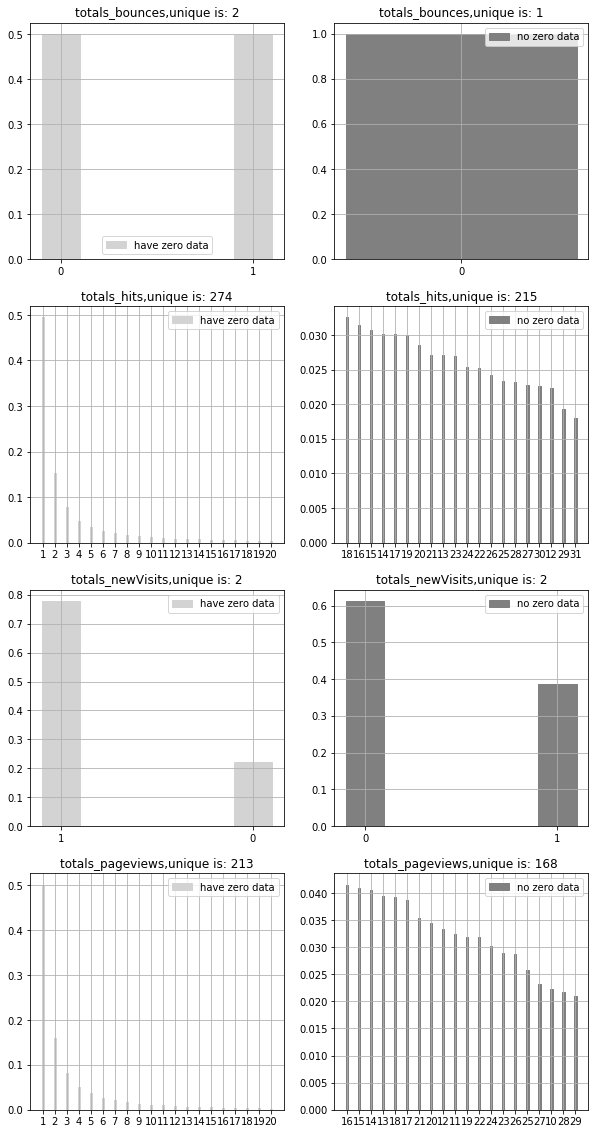

In [32]:
def plottotals(df,top=5):
    n = 1
    plt.figure(figsize=[10,20])
    for i in df.columns[16:20]:
        idx = df.totals_transactionRevenue.notnull()
        value_count1 = df[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = df[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(4,2,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},unique is: {df[i].nunique()}')
        plt.grid()
        plt.subplot(4,2,n+1)
        plt.grid()
        plt.bar(np.arange(value_count2.shape[0])+1.2,
                value_count2.values,           
                width=np.ones(value_count2.shape[0])*0.2,
                facecolor='gray',
                edgecolor='gray',
                tick_label=value_count2.index.values,
                label='no zero data')
        plt.title(f'{i},unique is: {df[idx][i].nunique()}')
        plt.legend()
        n = n+2
    plt.show()
    return None


plottotals(train,top=20)

emmmm~,一个了不起的发现，最终预测结果是否为0与totals_bounces相关，如果bounces=1则交易必然失败，但如果为0，也不一定成功。并且如果点击量与网页浏览量在10到30之间，则很有可能交易成功，并且我们还可以看到，老顾客购物意愿比从其他途径来的新客户更强烈。

In [ ]:
train['totals_bounces'] = train.totals_bounces.astype('float')
train['totals_hits'] = train.totals_hits.astype('flaot')
train['totals_newVisits'] = train.totals_newVisits.astype('float')
train['totals_pageviews'] = train.totals_pageviews.astype('float')

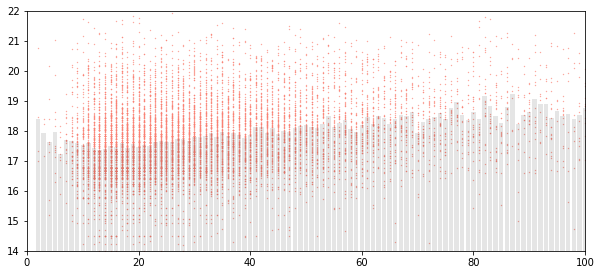

In [83]:
def scattertotals(df):
    idx = df.totals_transactionRevenue.notnull()
    df['totals_hits'] = df.totals_hits.astype('float')
    hits = df[idx].groupby('totals_hits').mean().target
    newvisit = df[idx].groupby('totals_newVisits').mean().target
    pageviews = df[idx].groupby('totals_pageviews').mean().target
    
    plt.figure(figsize=[10,15])
    plt.subplot(3,1,1)
    plt.bar(hits.index.values,hits.values,alpha=0.1,facecolor='k')
    plt.scatter(df.totals_hits.values,df.target.values,s=0.1,c='salmon')
    plt.ylim([14,22])
    plt.xlim([0,100])
    return None

scattertotals(train)

### trafficSource

In [103]:
train.iloc[:,21:34].head()

,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,None,None,None,None,None,None,(not set),None,None,(not provided),organic,None,google
1,None,None,None,None,None,None,(not set),None,None,(not provided),organic,None,google
2,None,None,None,None,None,None,(not set),None,None,(not provided),organic,None,google
3,None,None,None,None,None,None,(not set),None,None,google + online,organic,None,google
4,None,None,None,None,None,None,(not set),None,True,(not provided),organic,None,google


In [115]:
train.drop(['trafficSource_campaignCode'],axis=1,inplace=True)

11251kjhkvahf

In [132]:
idx = train.totals_transactionRevenue.notnull()

for i in train.columns[21:33]:
    print('\n',
          train[i].value_counts(),
          '\n',
          'len is: ', train[i].value_counts().shape[0],
          'Num is: ',sum(train[i].notnull()),
          'Nan is: ',sum(train[i].isnull()),
          '\n',
          '-'*80,
          '\n',
          train[idx][i].value_counts(),      
          '\n',
          'len is: ',train[idx][i].value_counts().shape[0],
          'Num is: ',sum(train[idx][i].notnull()),
          'Nan is: ',sum(train[idx][i].isnull()),
          '\n',
          '*'*80)


 Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
Google Merchandise                               87
First Full Auto Template Test Ad                 87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:G


 False    21460
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64 
 len is:  1 Num is:  21460 Nan is:  882193 
 -------------------------------------------------------------------------------- 
 False    454
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64 
 len is:  1 Num is:  454 Nan is:  11061 
 ********************************************************************************

 1     21362
2        73
3        10
5         7
7         3
4         2
9         2
14        1
Name: trafficSource_adwordsClickInfo.page, dtype: int64 
 len is:  8 Num is:  21460 Nan is:  882193 
 -------------------------------------------------------------------------------- 
 1    454
Name: trafficSource_adwordsClickInfo.page, dtype: int64 
 len is:  1 Num is:  454 Nan is:  11061 
 ********************************************************************************

 Top    20956
RHS      504
Name: trafficSource_adwordsClickInfo.slot, dtype: int64 
 len is:  2 Num is:  21460 Nan is:  88


 organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: trafficSource_medium, dtype: int64 
 len is:  7 Num is:  903653 Nan is:  0 
 -------------------------------------------------------------------------------- 
 referral     5415
organic      3438
(none)       2042
cpc           468
cpm           142
affiliate       9
(not set)       1
Name: trafficSource_medium, dtype: int64 
 len is:  7 Num is:  11515 Nan is:  0 
 ********************************************************************************

 /                                                                                                                                                                                                                   75523
/yt/about/                                                                                                                                                                             


 google                                               400788
youtube.com                                          212602
(direct)                                             143028
mall.googleplex.com                                   66416
Partners                                              16411
analytics.google.com                                  16172
dfa                                                    5686
google.com                                             4669
m.facebook.com                                         3365
baidu                                                  3356
sites.google.com                                       2983
facebook.com                                           2296
siliconvalley.about.com                                2097
reddit.com                                             2022
qiita.com                                              1813
quora.com                                              1546
bing                                  

In [ ]:
train.head()

In [ ]:
sum(train['trafficSource_adwordsClickInfo.isVideoAd'].isnull())